# Exploring DSIRE Database of State Incentives for Renewables & Efficiency
***

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format # display numbers as with thousands separator
pd.set_option('display.max_colwidth', None) # display full text in columns

from IPython.display import display, HTML
# Custom CSS to align DataFrame values to the right
css_rules = """
.output {flex-direction: row;}
<style>
    table.dataframe th, table.dataframe td {
        text-align: right !important;
    }
</style>
"""
# Apply the custom CSS
display(HTML(css_rules))

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# Save tables to a workbook
import openpyxl
wb = openpyxl.Workbook()
wb.save("Data/DSIRE/tables.xlsx")


C:\Users\svens\AppData\Local\Temp\ipykernel_23492\2108847101.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [59]:
dsire = pd.read_csv('Data/DSIRE/clean_dsire_data_off.csv')

# These will help to show display useful information since our main dataset uses id's instead of names
tech_dict = pd.read_csv('Data/DSIRE/technology_category.csv', usecols=['id', 'name'], index_col='id', dtype={"id" : str})['name'].to_dict()
sect_dict = pd.read_csv('Data/DSIRE/sector.csv', usecols=['id', 'name'], index_col='id', dtype={"id" : str})['name'].to_dict()


## Look at shape of data
***

In [60]:
print(f"Number of programs {dsire.shape[0]}")
print(f"Number of attributes {dsire.shape[1]}")

Number of programs 2460
Number of attributes 51


In [61]:
# Unique of program categories
producers = dsire['CategoryName'].unique()
print("Program Categories: ")
print (*producers, sep=", ")

Program Categories: 
Regulatory Policy, Financial Incentive


In [62]:
# Unique of program types
producers = dsire['TypeName'].unique()
print("Program Types: ")
print (*producers, sep=", ")

Program Types: 
Solar/Wind Access Policy, Personal Tax Deduction, Generation Disclosure, Mandatory Utility Green Power Option, Equipment Certification, Net Metering, Sales Tax Incentive, Property Tax Incentive, Corporate Tax Credit, Personal Tax Credit, Other Incentive, Industry Recruitment/Support, Corporate Tax Exemption, Public Benefits Fund, Renewables Portfolio Standard, Loan Program, Leasing Program, Corporate Tax Deduction, Rebate Program, Energy Standards for Public Buildings, Solar/Wind Contractor Licensing, Line Extension Analysis, Interconnection, Solar/Wind Permitting Standards, Green Power Purchasing, Performance-Based Incentive, Grant Program, Bond Program, Building Energy Code, Personal Tax Exemption, Corporate Depreciation, Green Building Incentive, Utility Rate Discount, Appliance/Equipment Efficiency Standards, Other Policy, PACE Financing, Energy Efficiency Resource Standard, Feed-in Tariff, Value of Solar Tariff, Solar Renewable Energy Credit Program, Energy Storage

In [63]:
# Unique values of applicable technologies for programs
techs = [v for k,v in tech_dict.items()]
print("Applicable Technologies: ")
print (*techs, sep=", ")

Applicable Technologies: 
Solar Technologies, Geothermal Technologies, Wind, Biomass, Hydroelectric, Fuel Cells, Other, Ocean Technologies, Appliances, HVAC, Lighting, Industrial Equipment, Other, Building Envelope, Battery, Other, Vehicles, Charging Equipment


In [64]:
# Unique values of applicable sectors for programs
sectors = [v for k,v in sect_dict.items()]
print("Applicable Sectors: ")
print (*sectors, sep=", ")

Applicable Sectors: 
Commercial, Construction, Industrial, Investor-Owned Utility, Local Government, Nonprofit, Municipal Utilities, Residential, Cooperative Utilities, Schools, State Government, Federal Government, Installers/Contractors, Tribal Government, Retail Supplier, Agricultural, Multifamily Residential, Low Income Residential, Institutional, Integrators, Non-Residential, Business, Public Sector, Residential, Other, Tribal Government, Utility, Builders and Installers, Appliance Manufacturers, Senior citizens, Senior citizens, Senior citizens


In [65]:
# Unique values of implementing sectors
sectors = dsire['ImplementingSectorName'].unique()
print("Implementing Sectors: ")
print (*sectors, sep=", ")

Implementing Sectors: 
State, Utility, Local, Non-Profit, Federal, Other


## Look for patterns with programs missing start dates
***

In [66]:
empty_dates = dsire[dsire['EarliestEnactedYear'] == 0]
type_counts = empty_dates['TypeName'].value_counts().to_frame()
sector_counts = empty_dates['ImplementingSectorName'].value_counts().to_frame()
state_counts = empty_dates['State'].value_counts().to_frame()

with pd.ExcelWriter("Data/DSIRE/tables.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        type_counts.to_excel(writer, sheet_name="types_noStart", index=True)
        sector_counts.to_excel(writer, sheet_name="sectors_noStart", index=True)
        state_counts.to_excel(writer, sheet_name="states_noStart", index=True)


display_side_by_side([type_counts, sector_counts, state_counts], ['Type Count w/Missing Start', 'Sector Count w/Missing Start', 'State Count w/Missing Start'])

,count
TypeName,
Rebate Program,1022
Loan Program,150
Grant Program,93
Building Energy Code,42
Solar/Wind Permitting Standards,26
Solar/Wind Access Policy,20
Net Metering,13
PACE Financing,10
Solar/Wind Contractor Licensing,8


## Counts of programs by various attributes
<a class="anchor" id="counts-of-programs-by-various-attributes"></a>
***
Attributes of interest:
1. Policy/Incentive Category
2. Policy/Incentive Type 
3. Implementing Sector (What type of entity enacted the program?)
4. Eligible Technologies (Which technologies does this program support?)
5. Eligible Sectors (Which sectors does this program support?)

In [67]:
cols_interest = ['CategoryName', 'TypeName', 'ImplementingSectorName']

attr_counts = {}

# Sectors and technologies are stored as binary categorical vars (0/1)
sect_counts = {}
for col in dsire.columns:
    if 'Sector_' in col:
        sec_name = sect_dict[col.split('_')[1]] # format is `Sector_id`
        sect_counts[sec_name] = dsire[col].sum() # binary categorical var so sum is the count

# Add sector counts to the collection of attribute counts
sect_series = pd.Series(sect_counts, name='Count')
sect_series.index.name = 'Applicable Sectors'
attr_counts['Applicable Sectors'] = sect_series

# See notes about sectors starting line 5
tech_counts = {}
for col in dsire.columns:
    if 'Tech_' in col:
        tech_name = tech_dict[col.split('_')[1]]
        tech_counts[tech_name] = dsire[col].sum()
tech_series = pd.Series(tech_counts, name='Count')
tech_series.index.name = 'Applicable Technologies'
attr_counts['Applicable Technologies'] = tech_series

# Find the value counts for the columns of interest
for col in cols_interest:
    attr_counts[col] = dsire[col].value_counts()

# Save the value counts to a workbook
with pd.ExcelWriter("Data/DSIRE/tables.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    for key, value in attr_counts.items():
        value.to_excel(writer, sheet_name=f'{key}_counts', index=True)

# Display the value counts for each column of interest
print('Value counts for each column of interest')
for key, value in attr_counts.items():
    print(key)
    display(value)
    print('\n')

Value counts for each column of interest
Applicable Sectors


Applicable Sectors
Senior citizens               1
Agricultural                401
Tribal Government            71
Construction                177
Integrators                  13
Nonprofit                   506
Municipal Utilities         131
Retail Supplier              45
Commercial                 1311
State Government            458
Cooperative Utilities       139
Appliance Manufacturers      10
Industrial                  838
Institutional               347
Installers/Contractors      142
Federal Government          518
Local Government            607
Schools                     454
Investor-Owned Utility      187
Low Income Residential      267
Residential                1375
Multifamily Residential     442
Name: Count, dtype: int64



Applicable Technologies


Applicable Technologies
Fuel Cells                  263
Biomass                     505
Wind                        608
Solar Technologies          949
Hydroelectric               371
Industrial Equipment        461
Building Envelope           536
Charging Equipment          284
Vehicles                    148
Other                      1140
Lighting                    590
HVAC                       1000
Appliances                  725
Geothermal Technologies     686
Battery                      79
Ocean Technologies          132
Name: Count, dtype: int64



CategoryName


CategoryName
Financial Incentive    1785
Regulatory Policy       675
Name: count, dtype: int64



TypeName


TypeName
Rebate Program                              1102
Loan Program                                 197
Grant Program                                129
Energy Standards for Public Buildings         95
Property Tax Incentive                        84
Building Energy Code                          79
Net Metering                                  71
Solar/Wind Access Policy                      67
Solar/Wind Permitting Standards               59
Sales Tax Incentive                           56
Renewables Portfolio Standard                 52
Interconnection                               49
PACE Financing                                45
Public Benefits Fund                          40
Industry Recruitment/Support                  34
Energy Efficiency Resource Standard           29
Personal Tax Credit                           26
Generation Disclosure                         25
Community Solar Rules                         24
Green Power Purchasing                        22
Corporate T



ImplementingSectorName


ImplementingSectorName
Utility       1142
State         1048
Local          228
Federal         33
Non-Profit       8
Other            1
Name: count, dtype: int64

### From those counts with the missing start-date counts we find that all of the rebate program in the dataset are missing start dates. Let's see which sector implemented these rebate programs to see if we can drop them.

In [68]:
# Find number of rebate programs by implemented sector
rebate = dsire[dsire['TypeName'] == 'Rebate Program']
rebate_sect_counts = rebate['ImplementingSectorName'].value_counts()
print('Number of rebate programs by implemented sector')
display(rebate_sect_counts)

Number of rebate programs by implemented sector


ImplementingSectorName
Utility       993
State          91
Local          16
Non-Profit      1
Other           1
Name: count, dtype: int64

## Counts of programs by state

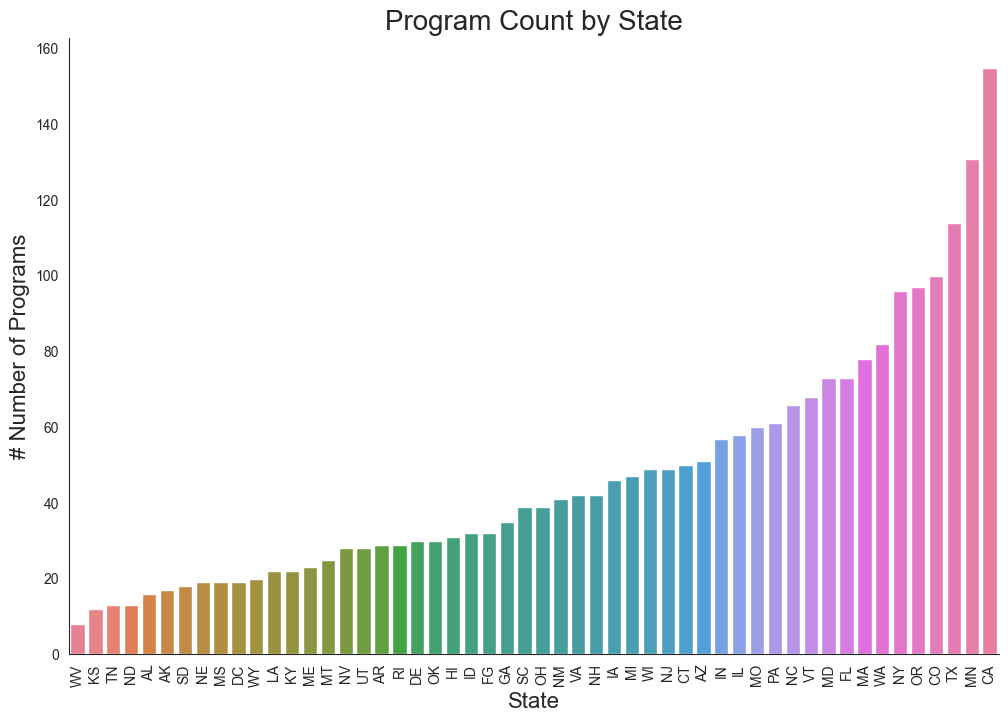

In [69]:
state_df = dsire.groupby(['State']).size().to_frame('Count')
state_df.sort_values(by=['Count'], inplace=True, ascending=True)

# Set appearance
sns.set_style("white")
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(state_df))

# Create the bar chart
sns.barplot(x="State", y="Count", data=state_df, palette=colors, hue="State")

# Set titles
plt.title("Program Count by State", fontsize=20)
plt.ylabel("# Number of Programs", fontsize=16)
plt.xlabel("State", fontsize=16)

# Rotate x ticks
plt.xticks(rotation=90)

sns.despine()
plt.savefig('Visuals/DSIRE/program_count_by_state.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Counts of programs by state and category
<a class="anchor" id="counts-of-programs-by-state-and-attributes"></a>
***

In [70]:
state_cat_df = dsire.groupby(['State', 'CategoryName']).size().to_frame('Count')

with pd.ExcelWriter("Data/DSIRE/tables.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        state_cat_df.to_excel(writer, sheet_name="stateXCategory_counts", index=True)

# Display number of programs by category for each state
print('Number of programs by category for each state')
for state in state_cat_df.index.levels[0]:
    display(*[state, state_cat_df.loc[state]])

Number of programs by category for each state


'AK'

,Count
CategoryName,
Financial Incentive,13
Regulatory Policy,4


'AL'

,Count
CategoryName,
Financial Incentive,14
Regulatory Policy,2


'AR'

,Count
CategoryName,
Financial Incentive,23
Regulatory Policy,6


'AZ'

,Count
CategoryName,
Financial Incentive,29
Regulatory Policy,22


'CA'

,Count
CategoryName,
Financial Incentive,106
Regulatory Policy,49


'CO'

,Count
CategoryName,
Financial Incentive,79
Regulatory Policy,21


'CT'

,Count
CategoryName,
Financial Incentive,34
Regulatory Policy,16


'DC'

,Count
CategoryName,
Financial Incentive,9
Regulatory Policy,10


'DE'

,Count
CategoryName,
Financial Incentive,16
Regulatory Policy,14


'FG'

,Count
CategoryName,
Financial Incentive,28
Regulatory Policy,4


'FL'

,Count
CategoryName,
Financial Incentive,54
Regulatory Policy,19


'GA'

,Count
CategoryName,
Financial Incentive,28
Regulatory Policy,7


'HI'

,Count
CategoryName,
Financial Incentive,16
Regulatory Policy,15


'IA'

,Count
CategoryName,
Financial Incentive,35
Regulatory Policy,11


'ID'

,Count
CategoryName,
Financial Incentive,27
Regulatory Policy,5


'IL'

,Count
CategoryName,
Financial Incentive,40
Regulatory Policy,18


'IN'

,Count
CategoryName,
Financial Incentive,49
Regulatory Policy,8


'KS'

,Count
CategoryName,
Financial Incentive,3
Regulatory Policy,9


'KY'

,Count
CategoryName,
Financial Incentive,17
Regulatory Policy,5


'LA'

,Count
CategoryName,
Financial Incentive,12
Regulatory Policy,10


'MA'

,Count
CategoryName,
Financial Incentive,58
Regulatory Policy,20


'MD'

,Count
CategoryName,
Financial Incentive,58
Regulatory Policy,15


'ME'

,Count
CategoryName,
Financial Incentive,7
Regulatory Policy,16


'MI'

,Count
CategoryName,
Financial Incentive,34
Regulatory Policy,13


'MN'

,Count
CategoryName,
Financial Incentive,116
Regulatory Policy,15


'MO'

,Count
CategoryName,
Financial Incentive,49
Regulatory Policy,11


'MS'

,Count
CategoryName,
Financial Incentive,15
Regulatory Policy,4


'MT'

,Count
CategoryName,
Financial Incentive,17
Regulatory Policy,8


'NC'

,Count
CategoryName,
Financial Incentive,42
Regulatory Policy,24


'ND'

,Count
CategoryName,
Financial Incentive,9
Regulatory Policy,4


'NE'

,Count
CategoryName,
Financial Incentive,14
Regulatory Policy,5


'NH'

,Count
CategoryName,
Financial Incentive,31
Regulatory Policy,11


'NJ'

,Count
CategoryName,
Financial Incentive,33
Regulatory Policy,16


'NM'

,Count
CategoryName,
Financial Incentive,27
Regulatory Policy,14


'NV'

,Count
CategoryName,
Financial Incentive,16
Regulatory Policy,12


'NY'

,Count
CategoryName,
Financial Incentive,76
Regulatory Policy,20


'OH'

,Count
CategoryName,
Financial Incentive,28
Regulatory Policy,11


'OK'

,Count
CategoryName,
Financial Incentive,22
Regulatory Policy,8


'OR'

,Count
CategoryName,
Financial Incentive,72
Regulatory Policy,25


'PA'

,Count
CategoryName,
Financial Incentive,50
Regulatory Policy,11


'RI'

,Count
CategoryName,
Financial Incentive,15
Regulatory Policy,14


'SC'

,Count
CategoryName,
Financial Incentive,33
Regulatory Policy,6


'SD'

,Count
CategoryName,
Financial Incentive,13
Regulatory Policy,5


'TN'

,Count
CategoryName,
Financial Incentive,10
Regulatory Policy,3


'TX'

,Count
CategoryName,
Financial Incentive,77
Regulatory Policy,37


'UT'

,Count
CategoryName,
Financial Incentive,18
Regulatory Policy,10


'VA'

,Count
CategoryName,
Financial Incentive,28
Regulatory Policy,14


'VT'

,Count
CategoryName,
Financial Incentive,56
Regulatory Policy,12


'WA'

,Count
CategoryName,
Financial Incentive,67
Regulatory Policy,15


'WI'

,Count
CategoryName,
Financial Incentive,36
Regulatory Policy,13


'WV'

,Count
CategoryName,
Financial Incentive,3
Regulatory Policy,5


'WY'

,Count
CategoryName,
Financial Incentive,15
Regulatory Policy,5


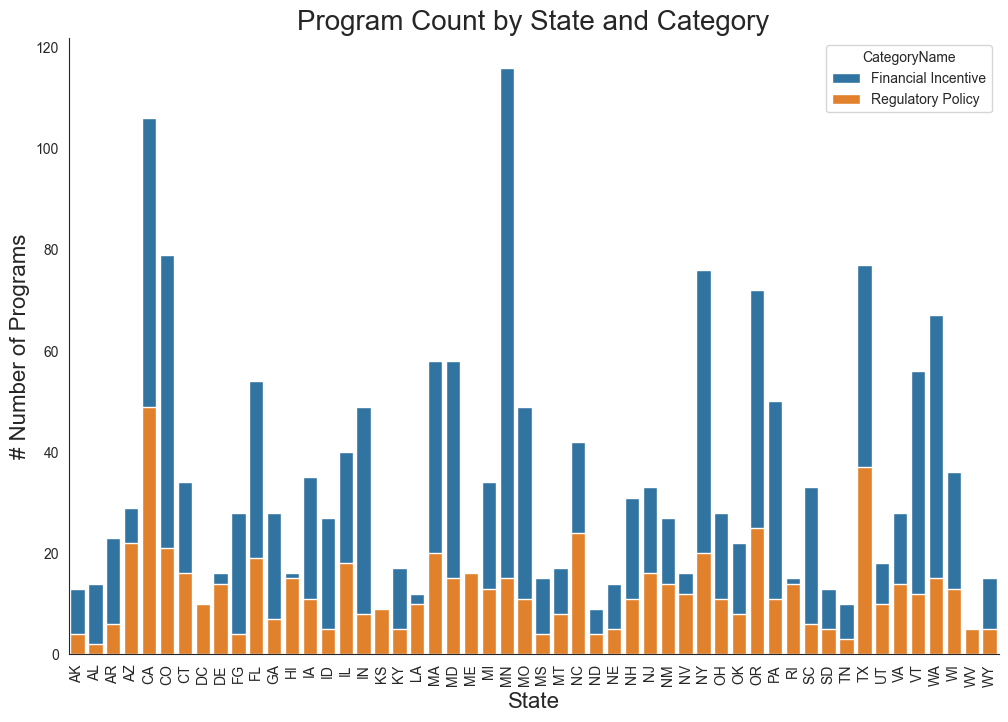

In [71]:
# Create a stacked bar chart of program counts by state and category
sns.set_style("white")
plt.figure(figsize=(12, 8))
sns.barplot(x="State", y="Count", hue="CategoryName", data=state_cat_df, dodge=False, estimator=sum)

# Set titles
plt.title("Program Count by State and Category", fontsize=20)
plt.xlabel("State", fontsize=16)
plt.ylabel("# Number of Programs", fontsize=16)

# Rotate x ticks
plt.xticks(rotation=90)

sns.despine()
plt.savefig('Visuals/DSIRE/program_count_by_state_and_category.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()